<a href="https://colab.research.google.com/github/aoifeoc04/PhishingDetectorModels/blob/main/Phishing_Email_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Phishing Classifier

##1. Downloads and Imports

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/phishingmodel_dataset.csv'
df = pd.read_csv(file_path)

##2. Create Phishing dataset

In [ ]:
df = df[df['label'] == 1].copy()

In [ ]:
df.shape

(19331, 2)

In [ ]:
df.head(10)

,text_combined,label
0,irreverent nomograph amend the only proven met...,1
1,make your rivals envy lt is really hard to rec...,1
2,copies everything - easy download or disc dupl...,1
4,microsoft update warning - january 7 th minnes...,1
5,hello andrea _ justice free teen action ! dear...,1
6,From Dr Usman Ibrahim / Mr Wahid Yoffe propert...,1
7,hottest teenage video galleries our teens port...,1
11,paracodin sells better than vicodin vitro aver...,1
15,"all graphics software available , cheap oem ve...",1
17,"urgent investor alert , big potential ! otc al...",1


##3. Pre-process

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text_combined'].apply(preprocess)

##4. Vectorisation

In [ ]:
vectoriser = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectoriser.fit_transform(df['clean_text'])

##5. Topic Modelling

In [ ]:
nmf_model = NMF(n_components=10, random_state=42)
W = nmf_model.fit_transform(tfidf)
H = nmf_model.components_

In [ ]:
def display_topics(H, feature_names, top_words=20):
    for topic_pos, topic in enumerate(H):
        print(f"Topic {topic_pos}: ", " | ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))

feature_names = vectoriser.get_feature_names_out()
display_topics(H, feature_names)

Topic 0:  bank | account | kin | fund | money | transaction | foreign | transfer | foreigner | claim | mr | deceased | business | relation | died | crash | department | million | discovered | dollar
Topic 1:  com | http | www | computron | free | message | rate | click | list | email | remove | link | mail | credit | net | info | offer | 000 | time | subject
Topic 2:  statement | company | stock | report | security | information | forward | gas | investment | news | looking | advice | price | market | act | event | performance | future | product | voip
Topic 3:  adobe | software | 95 | xp | 2004 | window | professional | mx | pro | macromedia | corel | photoshop | studio | microsoft | office | graphic | oem | need | oo | premiere
Topic 4:  account | email | josemonkeyorg | update | usaa | verify | message | paypal | click | security | monkeyorg | information | mailbox | dear | upgrade | password | service | mail | server | access
Topic 5:  lottery | number | 000 | winning | program | p

##6. Assign topics and confidence

In [ ]:
topic_assignments = W.argmax(axis=1)
df['topic'] = topic_assignments

In [ ]:
row_sums = W.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
W_normalized = W / row_sums
df['topic_confidence'] = W_normalized.max(axis=1)

In [ ]:
df.head()

,text_combined,label,clean_text,topic,topic_confidence
0,irreverent nomograph amend the only proven met...,1,irreverent nomograph amend proven metfhod enhw...,8,0.295833
1,make your rivals envy lt is really hard to rec...,1,make rival envy lt really hard recollect compa...,6,0.661078
2,copies everything - easy download or disc dupl...,1,copy everything easy download disc duplicator ...,1,0.357859
4,microsoft update warning - january 7 th minnes...,1,microsoft update warning january 7 th minnesot...,7,0.491600
5,hello andrea _ justice free teen action ! dear...,1,hello andrea _ justice free teen action dear a...,1,0.600439


In [ ]:
topic_names = {
    0: "Advance Fee Scam / Inheritance Scam",
    1: "Link-based Scam",
    2: "Investment Scam",
    3: "Software/ Product Scam",
    4: "Account Verification Phishing ",
    5: "Lottery/Prize Scam",
    6: "Business / Branding Scam",
    7: "Bank Account / Transaction Scam",
    8: "SEO / Traffic Scam",
    9: "Medication / Enhancement Scam"
}

In [ ]:
df['phishing_category'] = df['topic'].map(topic_names)

In [ ]:
category_counts = df['topic'].value_counts()
print(category_counts)

topic
1    5674
9    3237
7    2981
4    1865
0    1693
3    1259
2    1174
5     548
6     470
8     430
Name: count, dtype: int64


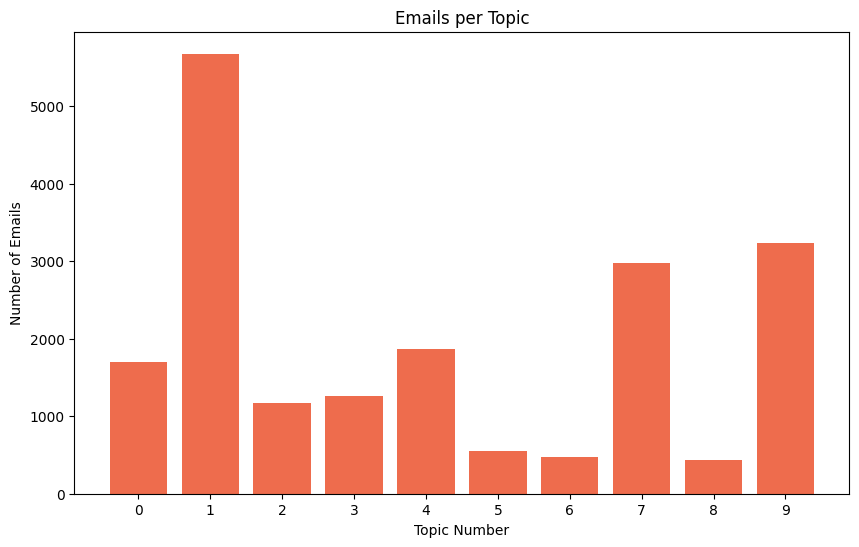

In [ ]:
import matplotlib.pyplot as plt

topic_counts = df['topic'].value_counts().sort_index()
plt.figure(figsize=(10,6))
plt.bar(topic_counts.index, topic_counts.values, color='#ee6c4d')
plt.xlabel("Topic Number")
plt.ylabel("Number of Emails")
plt.title("Emails per Topic")
plt.xticks(range(10))
plt.show()

##7. Filter by Confidence scores

###7.1 High Confidence

In [ ]:
confident_mask = df['topic_confidence'] >= 0.5
df_confident = df[confident_mask]
W_confident = W[confident_mask.values]

In [ ]:
df_confident.shape

(12407, 6)

In [ ]:
category_counts = df_confident['topic'].value_counts()
print(category_counts)

topic
1    3000
9    2202
7    1966
4    1456
0    1159
3     923
2     855
5     344
6     324
8     178
Name: count, dtype: int64


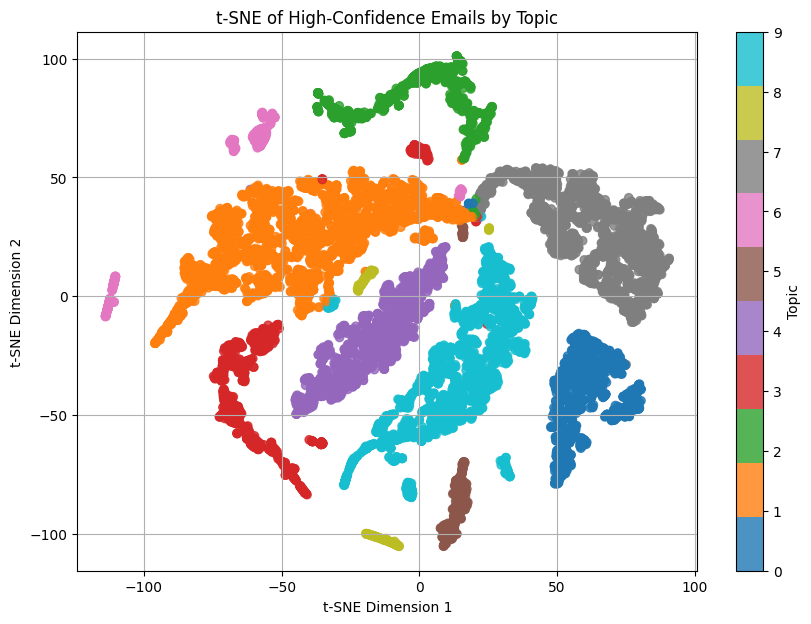

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
W_2d_conf = tsne.fit_transform(W_confident)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(W_2d_conf[:, 0], W_2d_conf[:, 1], c=df_confident['topic'], cmap='tab10', alpha=0.8)
plt.title("t-SNE of High-Confidence Emails by Topic")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(scatter, label="Topic")
plt.grid(True)
plt.show()

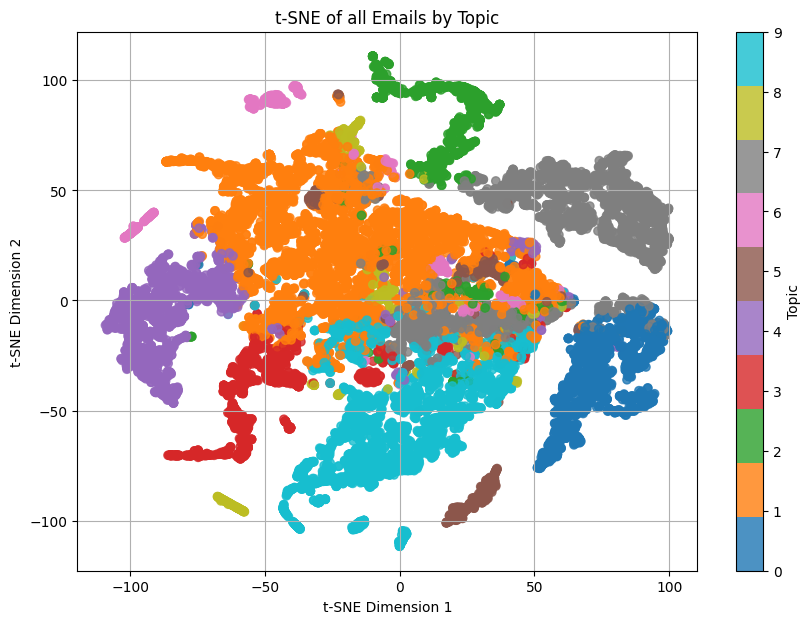

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
W_2d_conf = tsne.fit_transform(W)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(W_2d_conf[:, 0], W_2d_conf[:, 1], c=df['topic'], cmap='tab10', alpha=0.8)
plt.title("t-SNE of all Emails by Topic")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(scatter, label="Topic")
plt.grid(True)
plt.show()

##8. View Emails

In [ ]:
for category in df['phishing_category'].dropna().unique():
    print(f"\nCategory: {category}")

    sample_row = df_confident[df_confident['phishing_category'] == category].sample(1, random_state=None)

    sample_email = sample_row.iloc[0]['text_combined']
    print(sample_email[:1000])



Category: SEO / Traffic Scam
you don _ t know how to get into search engine results ? submitting your website in search engines may increase
your online sales dramatically .
if you invested time and money into your website , you
simply must submit your website
oniine otherwise it wili be invisible virtually , which means efforts spent in vain .
lf you want
peopie to know about your website and boost your revenues , the only way to do
that is to
make your site visibie in places
where people search for information , i . e .
submit your
website in multipie search engines .
submit your website online
and watch visitors stream to your e - business .
best regards ,
delmarhopkins _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ not interested . . . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

Category: Business / Branding Scam
need a graphic artist ? come here . thinking of brea

##8. Train model

In [ ]:
vectoriser = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

tfidf_confident = vectoriser.fit_transform(df_confident['clean_text'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_confident, df_confident['topic'], test_size=0.25, random_state=42)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Multinomial Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [ ]:
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       323
           1       0.89      1.00      0.94       747
           2       1.00      0.92      0.96       218
           3       1.00      0.90      0.95       230
           4       0.99      1.00      1.00       329
           5       1.00      0.84      0.91        82
           6       1.00      0.91      0.95        85
           7       1.00      0.97      0.98       499
           8       1.00      0.86      0.92        42
           9       0.98      0.96      0.97       547

    accuracy                           0.97      3102
   macro avg       0.99      0.93      0.96      3102
weighted avg       0.97      0.97      0.97      3102


Random Forest
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       323
           1       0.91      0.99      0.95       747
           2       1.00      0.93      0.9

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:00:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      0.99      0.99       323
           1       0.94      0.99      0.96       747
           2       1.00      0.96      0.98       218
           3       0.98      0.99      0.99       230
           4       0.98      0.99      0.98       329
           5       1.00      0.90      0.95        82
           6       1.00      0.94      0.97        85
           7       0.99      0.98      0.99       499
           8       1.00      0.93      0.96        42
           9       0.98      0.97      0.97       547

    accuracy                           0.98      3102
   macro avg       0.99      0.96      0.97      3102
weighted avg       0.98      0.98      0.98      3102



##9. Final model

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(tfidf_confident, df_confident['topic'], test_size=0.25, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

y_pred_xgb = model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:03:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


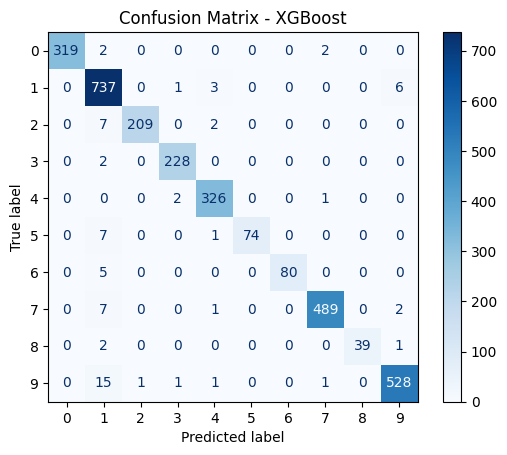

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [ ]:
real_email = """
4	microsoft update warning - january 7 th minnesota , which can clinch a wild - card playoff spot with a loss by either carolina or st . louis this weekend , appeared on its way to retaking the lead . but a holding penalty on birk - - the vikings were flagged nine times for 78 yards - - wiped out a 16 - yard run by michael bennett that would have given them the ball at the green bay 40 just before the 2 - minute warning . the vikings ( 8 - 7 ) , though , couldn ' t get what they needed from a pass defense that has struggled all season . government spokesman raanan gissin said four soldiers were killed . six people were taken to hospital - - four badly hurt , one with moderate injuries and one lightly injured , military sources said . the sources said another soldier remained beneath the rubble . gissin said rescue operations were continuing sunday night . the attack " indicates that unless there is decisive and sustained effort taken to dismantle the terrorist organization , it will be impossible to move towards normalizations and towards political negotiations , " gissin told a news crew . " and i think the responsibility on that lies with the palestinian authority . " shortly after the first blast , a second explosion was heard in southern gaza , but its precise location was not immediately known . hamas , in a phone call to cnn , said it had set off the first explosion near rafah in cooperation with a group called the fatah hawks . there was no immediate information available on that group , although it was believed to be linked to the fatah movement formerly led by the late palestinian leader yasser arafat . israeli military sources said it was a coordinated attack , with palestinians firing mortar shells and guns at the post when the explosives were detonated . it was not clear whether there were palestinian casualties . news video of the aftermath showed soldiers using stretchers to transport troops who appeared to be severely wounded . in a pamphlet distributed after the attack , hamas said it had used 1 . 5 tons of explosives and had recorded video of the incident . palestinians have used tunnels in the area to smuggle weapons from egypt . israel has carried out operations to crack down on the smuggling . shell explosion in schoolyard an israeli tank shell exploded in a gaza schoolyard sunday morning , wounding eight palestinian schoolchildren , palestinian medical and security sources said . the children between the ages of 6 and 12 - - sustained moderate to light injuries , the sources said . the violence happened in khan yunis in central gaza israeli military sources said that forces in the area identified what they thought was a number of mortar shells being fired towards israeli settlements nearby . in response , the forces fired towards the positions with light weapons , but did not fire a tank shell , the military sources said .
"""

real_email_clean = preprocess(real_email)

X_real = vectoriser.transform([real_email_clean])

predicted_category = model.predict(X_real)[0]
print("Predicted Category:", predicted_category)

Predicted Category: 7


##10. Download model

In [ ]:
import pickle

with open('phishing_type_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
from google.colab import files
files.download('phishing_type_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('phishing_type_vectoriser.pkl', 'wb') as file:
    pickle.dump(vectoriser, file)

In [ ]:
files.download('phishing_type_vectoriser.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>